In [81]:
import argparse
import torch
import numpy as np
from typing import Optional
import sys
sys.path.append('../')
from acds.archetypes import RandomizedOscillatorsNetwork
from att_dim_experiments.utils import  load_results
import pandas as pd
from pandas import DataFrame
from skdim.id import lPCA, CorrInt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn.decomposition import PCA
tqdm.pandas()


In [82]:

def compute_corr_dim(trajectory: np.ndarray, k1=5,  k2=20, transient=2000) -> Optional[list[float]]:
    corr_dim_values = []
    for i in range(trajectory.shape[1]): # for each module in the network
        corr_dim_estimator = CorrInt(k1=k1, k2=k2)
        try:
            traj_i = trajectory[transient:, i]
            corr_dim = corr_dim_estimator.fit_transform(traj_i)
            corr_dim_values.append(corr_dim)
        except Exception as e:
            print(f"Error computing correlation dimension: {e}")
            return None
    return corr_dim_values



In [83]:

N_HID = 3
COMPUTE_CORR_DIMS = False
#trajectory_path = "../trajectories/cycle_trajectories_collection.pkl"
trajectory_path = f"../trajectories/trajectories_collection_dim{N_HID}.pkl"

#df = DataFrame(data)

if COMPUTE_CORR_DIMS:
    data = load_results(trajectory_path)
    meta = dict(data['metadata'])
    df = DataFrame([
    {**t, **h}
    for t, h in zip(data["trajectories"], data["hyperparameters"])
    ])
    corr_dim = lambda traj: compute_corr_dim(traj)
    df['corr_dim'] = df['h'].progress_map(corr_dim)
    df.to_pickle(trajectory_path.replace('.pkl', '_with_corrdim.pkl'))
    
else:
    df = pd.read_pickle(trajectory_path.replace('.pkl', '_with_corrdim.pkl'))

df.head()


,h,c,n_modules,n_hid,rho,input_scaling,mixing_scaling,seed,corr_dim
0,"[[[-2.778268, 0.09828893, 1.3864002], [0.00046...","[[[-0.8074274, -1.0922141, -0.946456], [0.9454...",16,3,0.5,0.01,0.1,0,"[2.841012313120221, 2.2611771812133625, 1.9908..."
1,"[[[-1.3205618, -0.335962, -0.5994767], [1.0840...","[[[-1.0118331, -0.28867865, -0.879685], [0.051...",16,3,0.5,0.01,0.1,1,"[2.7893719727915527, 2.239978604246151, 1.9829..."
2,"[[[0.21181218, 0.08017199, -0.96964717], [-1.3...","[[[-0.11708291, -0.272558, -1.5040413], [-0.04...",16,3,0.5,0.01,0.1,2,"[2.806802755416452, 2.202826479879226, 1.98514..."
3,"[[[0.81506497, 0.55876863, 0.124593705], [1.34...","[[[-1.1517178, -0.35150844, 0.70622534], [-0.3...",16,3,0.5,0.01,0.1,3,"[2.7148385023544126, 2.244081416321241, 1.9819..."
4,"[[[0.16155645, -1.4389366, 2.070297], [0.45656...","[[[0.34178934, 0.2703758, 1.6991528], [0.72459...",16,3,0.5,0.01,0.1,4,"[2.8168100616007052, 2.2320255596041103, 1.978..."


In [84]:
max_tr = df['h'].apply(lambda x: np.max(x[2000:]))
min_tr = df['h'].apply(lambda x: np.min(x[2000:]))
print(f"Overall max trajectory value: {max_tr.max()}")
print(f"Overall min trajectory value: {min_tr.min()}")

Overall max trajectory value: 1.000000238418579
Overall min trajectory value: -1.000000238418579


In [85]:
def replace_nan_with_zero(col: pd.Series) -> pd.Series:
    def fix_nan(x):
        if isinstance(x, list):
            return [0.0 if (isinstance(v, float) and np.isnan(v)) else v for v in x]
        return x
    return col.apply(fix_nan)

df['corr_dim'] = replace_nan_with_zero(df['corr_dim'])

In [86]:
# group by 'n_modules', 'n_hid', 'rho', 'input_scaling' take the mean/std of the per-row corr_dim values
# drop h, c and seed (only if present)

cols_to_drop = [c for c in ['h', 'c', 'seed'] if c in df.columns]
df_corr_dim = df.drop(columns=cols_to_drop)

# corr_dim is stored as a list per row (one value per module). Prefer using a scalar summary per row:
# if corr_dim_val is already present (mean of the list), use it; otherwise compute it here.
if 'corr_dim_val' not in df_corr_dim.columns:
	df_corr_dim['corr_dim_val'] = df_corr_dim['corr_dim'].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

# group and compute mean/std over the scalar corr_dim_val (avoids aggregating object lists)
grouped_df = df_corr_dim.groupby(['n_modules', 'n_hid', 'rho', 'input_scaling', 'mixing_scaling'])['corr_dim_val'].agg(['mean', 'std']).reset_index()


# change column name from mean and std to corr_dim_mean and corr_dim_std
grouped_df = grouped_df.rename(columns={'mean': 'corr_dim_mean', 'std':
									 'corr_dim_std'})

# save to csv
grouped_df.head()

,n_modules,n_hid,rho,input_scaling,mixing_scaling,corr_dim_mean,corr_dim_std
0,1,3,0.5,0.01,0.1,2.478101,0.031815
1,1,3,0.5,0.01,0.5,2.788717,0.032753
2,1,3,0.5,0.01,1.0,2.653615,0.041042
3,1,3,0.5,0.01,2.0,1.956511,0.029266
4,1,3,0.5,0.10,0.1,2.094952,0.024954


In [87]:
# scatter n_modules vs corr_dim_mean, errorbar corr_dim_std, hue rho

In [88]:
hyperparams = [ 'n_modules', 'rho', 'input_scaling', 'mixing_scaling']

for p in hyperparams:
    corr = grouped_df['corr_dim_mean'].corr(grouped_df[p])
    print(f"Correlation between corr_dim and {p}: {corr}")
    


Correlation between corr_dim and n_modules: 0.018688762258316644
Correlation between corr_dim and rho: -0.2825856023424501
Correlation between corr_dim and input_scaling: -0.8001928204883151
Correlation between corr_dim and mixing_scaling: -0.3282464479649571


In [89]:
grouped_df.head(10)

,n_modules,n_hid,rho,input_scaling,mixing_scaling,corr_dim_mean,corr_dim_std
0,1,3,0.5,0.01,0.1,2.478101,0.031815
1,1,3,0.5,0.01,0.5,2.788717,0.032753
2,1,3,0.5,0.01,1.0,2.653615,0.041042
3,1,3,0.5,0.01,2.0,1.956511,0.029266
4,1,3,0.5,0.10,0.1,2.094952,0.024954
5,1,3,0.5,0.10,0.5,2.788796,0.030655
6,1,3,0.5,0.10,1.0,2.583010,0.040588
7,1,3,0.5,0.10,2.0,1.953141,0.030975
8,1,3,0.5,1.00,0.1,2.028085,0.029229
9,1,3,0.5,1.00,0.5,2.407572,0.048814


In [90]:
# add corr_dim_mean and corr_dim_std to the original df
df = df.merge(grouped_df, on=['n_modules', 'n_hid', 'rho', 'input_scaling', 'mixing_scaling'], how='left')
df.head()

,h,c,n_modules,n_hid,rho,input_scaling,mixing_scaling,seed,corr_dim,corr_dim_mean,corr_dim_std
0,"[[[-2.778268, 0.09828893, 1.3864002], [0.00046...","[[[-0.8074274, -1.0922141, -0.946456], [0.9454...",16,3,0.5,0.01,0.1,0,"[2.841012313120221, 2.2611771812133625, 1.9908...",2.502862,0.013313
1,"[[[-1.3205618, -0.335962, -0.5994767], [1.0840...","[[[-1.0118331, -0.28867865, -0.879685], [0.051...",16,3,0.5,0.01,0.1,1,"[2.7893719727915527, 2.239978604246151, 1.9829...",2.502862,0.013313
2,"[[[0.21181218, 0.08017199, -0.96964717], [-1.3...","[[[-0.11708291, -0.272558, -1.5040413], [-0.04...",16,3,0.5,0.01,0.1,2,"[2.806802755416452, 2.202826479879226, 1.98514...",2.502862,0.013313
3,"[[[0.81506497, 0.55876863, 0.124593705], [1.34...","[[[-1.1517178, -0.35150844, 0.70622534], [-0.3...",16,3,0.5,0.01,0.1,3,"[2.7148385023544126, 2.244081416321241, 1.9819...",2.502862,0.013313
4,"[[[0.16155645, -1.4389366, 2.070297], [0.45656...","[[[0.34178934, 0.2703758, 1.6991528], [0.72459...",16,3,0.5,0.01,0.1,4,"[2.8168100616007052, 2.2320255596041103, 1.978...",2.502862,0.013313


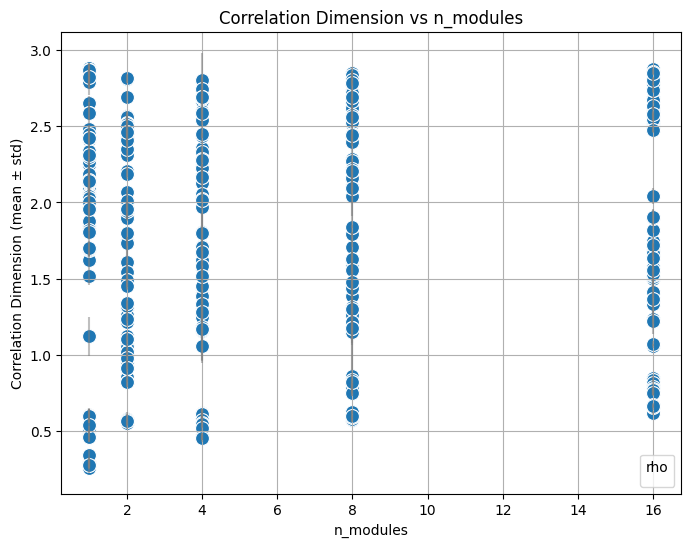

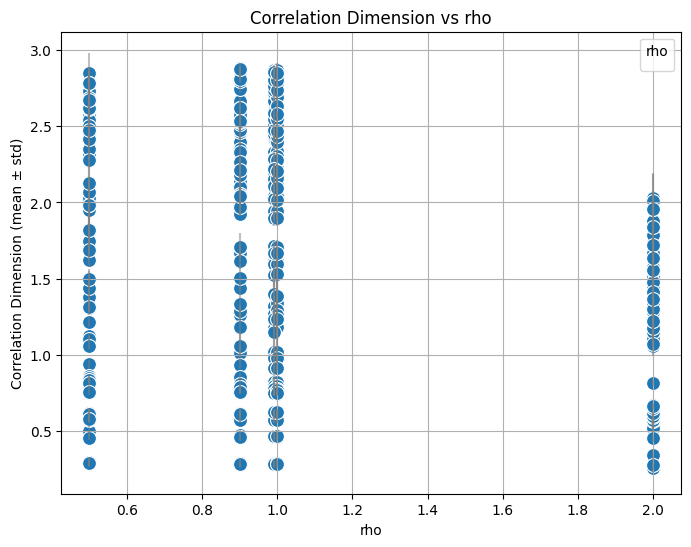

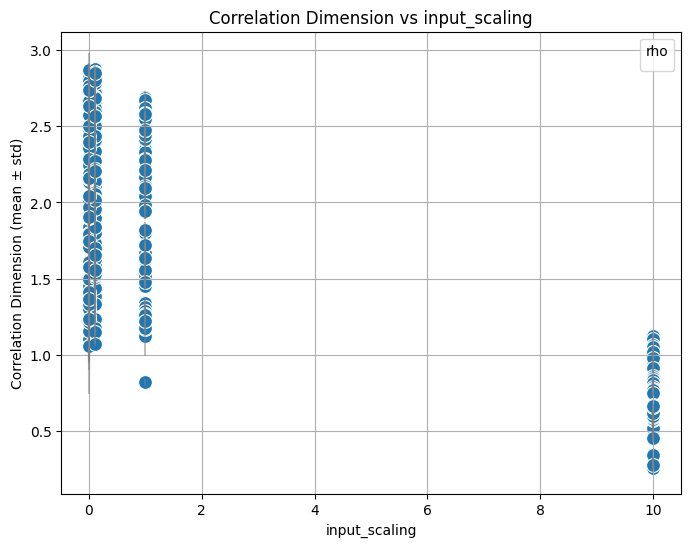

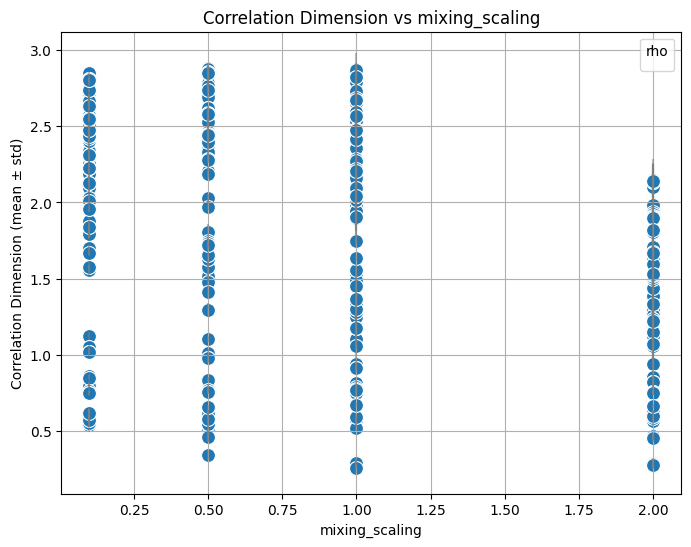

In [91]:
# plot hyperparams vs corr_dim_mean with errorbars corr_dim_std
for p in hyperparams:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=grouped_df, x=p, y='corr_dim_mean', palette='viridis', s=100)
    plt.errorbar(grouped_df[p], grouped_df['corr_dim_mean'], yerr=grouped_df['corr_dim_std'], fmt='none', c='gray', alpha=0.5)
    plt.title(f'Correlation Dimension vs {p}')
    plt.xlabel(p)
    plt.ylabel('Correlation Dimension (mean ± std)')
    plt.legend(title='rho')
    plt.grid(True)
    plt.show()

In [92]:

from itertools import cycle
from matplotlib import colors as mcolors

def plot_multiple_fading_trajectories(
        trajectories,
        transient = 0,
        labels=None,
        alpha_start=0.1,
        alpha_end=1.0,
        line_alpha=0.5,
        line_width=0.,
        marker=3,
        ax=None):
    """
    Plot multiple trajectories with progressive transparency.

    Parameters
    ----------
    trajectories : list of (x, y)
        Each trajectory is a pair of equal-length arrays.
    transient : int
        Transient of the trajectories
    labels : list of str, optional
        Labels for each trajectory. If None, no labels are added.
    alpha_start, alpha_end : float
        Start and end alpha for fading scatter points.
    line_alpha : float
        Transparency of connecting line.
    line_width : float
        Width of connecting line.
    marker : int
        Size of scatter markers.
    ax : matplotlib Axes, optional
        Axes to plot on. If None, a new one is created.
    
    Returns
    -------
    ax : matplotlib Axes
    """

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    # Matplotlib default color cycle

    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

    # Auto-generate labels if user passes None
    if labels is None:
        labels = [None] * len(trajectories)

    for (x, y), label in zip(trajectories, labels):
        x = np.asarray(x)
        y = np.asarray(y)
        x = x[transient:]
        y = y[transient:]
        n = len(x)

        # Get next line color from Matplotlib automatic cycle
        base_color = next(color_cycle)

        # Fading alphas
        alphas = np.linspace(alpha_start, alpha_end, n)

        # Convert base_color (RGB) to per-point RGBA list
        rgb = mcolors.to_rgb(base_color)
        colors = [(rgb[0], rgb[1], rgb[2], a) for a in alphas]

        # Plot line with label
        ax.plot(x, y, color=base_color, alpha=line_alpha, linewidth=line_width, label=label)

        # Scatter with varying transparency
        ax.scatter(x, y, c=colors, s=marker)

    if any(label is not None for label in labels):
        ax.legend()

    return ax



In [93]:
def plot_selection(
    df,
    n_modules_list = [1, 2, 4, 8, 16],
    rho = 1.,
    rho_m = 1.,
    input_scaling = 10.,
    n_hid = 3,
    seed = 0,
    coord_to_plot = (0, 1),
    transient=2000,
    output_path='figures/',
    plot_pca =True,
    plot_only_one=True,
    traj_to_plot=3
):
    df_sel = df[
        (df["n_hid"] == n_hid) &
        (df["rho"] == rho) &
        (df["mixing_scaling"] == rho_m) &
        (df["input_scaling"] == input_scaling) &
        (df["seed"] == seed)
    ].reset_index()
    fig, axes = plt.subplots(1, len(n_modules_list) , figsize=(5 * len(n_modules_list), 5))
    c1, c2 = coord_to_plot

    for ax, n_modules in zip(axes, n_modules_list):

        traj = df_sel[df_sel['n_modules']==n_modules]['h'].values[0]
        if not plot_pca:
            x = [traj[:, i, c1] for i in range(n_modules)]
            y = [traj[:, i, c2] for i in range(n_modules)]
        else:
            # perform pca on the trajectory concatenating all modules
            pca = PCA(n_components=3)
            x = []
            y = []
            for i in range(n_modules):
                traj_i = traj[:, i, :]
                traj_i_pca = pca.fit_transform(traj_i)
                x.append(traj_i_pca[:, 0])
                y.append(traj_i_pca[:, 1])
        if plot_only_one:
            t = min(traj_to_plot, n_modules - 1)
            x = [x[t]]
            y = [y[t]]
        plot_multiple_fading_trajectories(
            trajectories=list(zip(x, y)),
            transient=transient,
            ax=ax
        )
        # set legend to corr_dim value
        corr_dim_val = df_sel[df_sel['n_modules']==n_modules]['corr_dim_mean'].values[0]
        ax.legend([f"corr_dim = {corr_dim_val:.2f}"])
        ax.set_title(f"n_modules = {n_modules}")
        
    # set super title
    fig.suptitle(f"Trajectories for n_hid={n_hid}, rho={rho}, input_scaling={input_scaling}, rho_m={rho_m} seed={seed}", fontsize=16)
    plt.tight_layout()
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    out_path = output_path + f"n_hid_{n_hid}/"
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    plt.savefig(out_path+ f"trajectories_nhid{n_hid}_rho{rho}_inputscaling{input_scaling}_rho_m{rho_m}_seed{seed}.pdf")


In [94]:
for key in df.keys():
    if key == 'h' or key == 'c' or key == 'corr_dim' or key == 'corr_dim_val':
        continue
    print(f"{key}:")
    print(df[key].unique()) 

n_modules:
[16  8  4  2  1]
n_hid:
[3]
rho:
[0.5  0.9  0.99 1.   2.  ]
input_scaling:
[ 0.01  0.1   1.   10.  ]
mixing_scaling:
[0.1 0.5 1.  2. ]
seed:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
corr_dim_mean:
[2.5028619  2.78156502 1.74672043 1.49729392 2.6156138  2.78189584
 2.68502936 1.68700611 2.47282157 2.61831925 2.66940076 1.82135697
 0.84819064 0.83713982 0.81729862 0.75593086 2.79864528 2.87016842
 2.04011981 1.33420714 2.81009377 2.87669494 2.59133195 1.50715449
 2.57488059 2.62135655 2.53659464 1.70756487 0.76389028 0.77003251
 0.78721927 0.757985   2.73609145 2.76214471 1.89763813 1.2332837
 2.8060054  2.85428394 2.56811844 1.52189343 2.54991807 2.58406533
 2.47828639 1.67106769 0.74801509 0.7560958  0.772994   0.75141488
 2.63254481 2.73758666 1.90078454 1.2351947  2.80513269 2.84683724
 2.5667764  1.52780838 2.54636458 2.57822241 2.47151728 1.66728607
 0.74672794 0.75460676 0.77105343 0.75052171 1.57634068 1.41353662
 1.3

n_modules:
[16  8  4  2  1]
n_hid:
[16]
rho:
[0.5  0.9  0.99 1.   2.  ]
input_scaling:
[ 0.01  0.1   1.   10.  ]
mixing_scaling:
[0.1 0.5 1.  2. ]


In [95]:
def compute_participation_ratio(row):
    h = row['h']
    n_modules = h.shape[1]
    participation_ratios = []
    for i in range(n_modules):
        traj_i = h[:, i, :]
        # compute covariance matrix
        cov_matrix = np.cov(traj_i, rowvar=False)
        # compute eigenvalues
        eigenvalues = np.linalg.eigvalsh(cov_matrix)
        # compute participation ratio
        pr = (np.sum(eigenvalues))**2 / np.sum(eigenvalues**2)
        participation_ratios.append(pr)
    return participation_ratios

df['participation_ratio'] = df.apply(compute_participation_ratio, axis=1)
df['partitipation_ratio_mean'] = df['participation_ratio'].apply(lambda x: np.mean(x))


In [96]:
# group by 'n_modules', 'n_hid', 'rho', 'input_scaling', 'mixing_scaling' take the mean/std of the per-row partitipation_ratio_mean values

cols_to_drop = [c for c in ['h', 'c', 'seed', 'corr_dim', 'corr_dim_val'] if c in df.columns]
df_pr = df.drop(columns=cols_to_drop)
grouped_df_pr = df_pr.groupby(['n_modules', 'n_hid', 'rho', 'input_scaling', 'mixing_scaling'])['partitipation_ratio_mean'].agg(['mean', 'std']).reset_index()
# change column name from mean and std to pr_mean and pr_std
grouped_df_pr = grouped_df_pr.rename(columns={'mean': 'pr_mean', 'std': 'pr_std'})

grouped_df_pr.head()


,n_modules,n_hid,rho,input_scaling,mixing_scaling,pr_mean,pr_std
0,1,3,0.5,0.01,0.1,1.261512,0.200316
1,1,3,0.5,0.01,0.5,1.528445,0.359265
2,1,3,0.5,0.01,1.0,1.004962,0.002842
3,1,3,0.5,0.01,2.0,1.002149,0.001592
4,1,3,0.5,0.10,0.1,1.292912,0.091499


In [97]:
# compute correlation between pr_mean and corr_dim_mean
hyperparams = ['n_modules', 'n_hid', 'rho', 'input_scaling', 'mixing_scaling']
for p in hyperparams:
    corr = grouped_df_pr['pr_mean'].corr(grouped_df[p])
    print(f"Correlation between pr_mean and {p}: {corr}")

corr = grouped_df_pr['pr_mean'].corr(grouped_df['corr_dim_mean'])
print(f"Correlation between pr_mean and corr_dim_mean: {corr}")

# merge grouped_df and grouped_df_pr
grouped_df = grouped_df.merge(grouped_df_pr, on=['n_modules', 'n_hid', 'rho', 'input_scaling', 'mixing_scaling'], how='left')
grouped_df.head()
grouped_df.to_csv(trajectory_path.replace('.pkl', '_corrdim_pr_summary.csv'), index=False)

Correlation between pr_mean and n_modules: 0.24328046906582113
Correlation between pr_mean and n_hid: nan
Correlation between pr_mean and rho: 0.12754678907500736
Correlation between pr_mean and input_scaling: -0.21468543727458733
Correlation between pr_mean and mixing_scaling: 0.1498475841547888
Correlation between pr_mean and corr_dim_mean: 0.2046942828957058


In [98]:
grouped_df

,n_modules,n_hid,rho,input_scaling,mixing_scaling,corr_dim_mean,corr_dim_std,pr_mean,pr_std
0,1,3,0.5,0.01,0.1,2.478101,0.031815,1.261512,0.200316
1,1,3,0.5,0.01,0.5,2.788717,0.032753,1.528445,0.359265
2,1,3,0.5,0.01,1.0,2.653615,0.041042,1.004962,0.002842
3,1,3,0.5,0.01,2.0,1.956511,0.029266,1.002149,0.001592
4,1,3,0.5,0.10,0.1,2.094952,0.024954,1.292912,0.091499
...,...,...,...,...,...,...,...,...,...
395,16,3,2.0,1.00,2.0,1.224103,0.019896,2.209838,0.007006
396,16,3,2.0,10.00,0.1,0.617820,0.014366,1.685731,0.009501
397,16,3,2.0,10.00,0.5,0.654588,0.014830,1.725262,0.010379
398,16,3,2.0,10.00,1.0,0.672400,0.013386,1.813340,0.011044


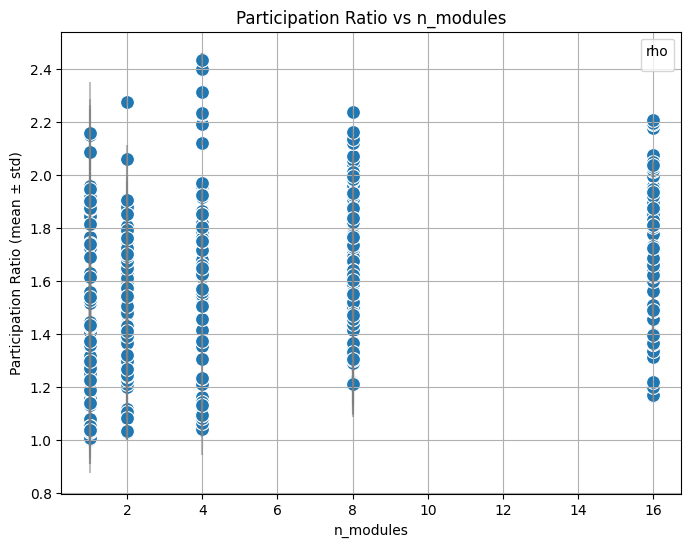

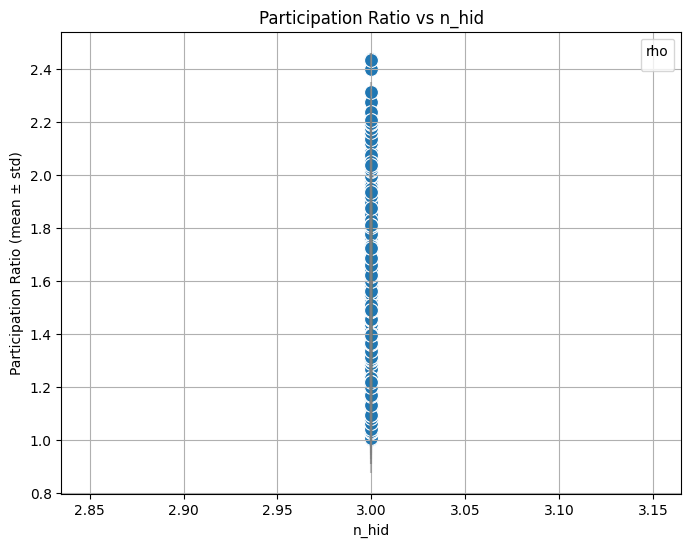

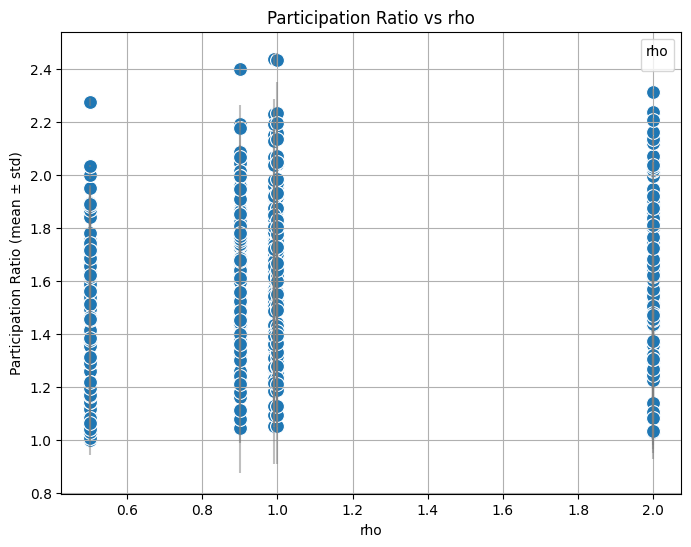

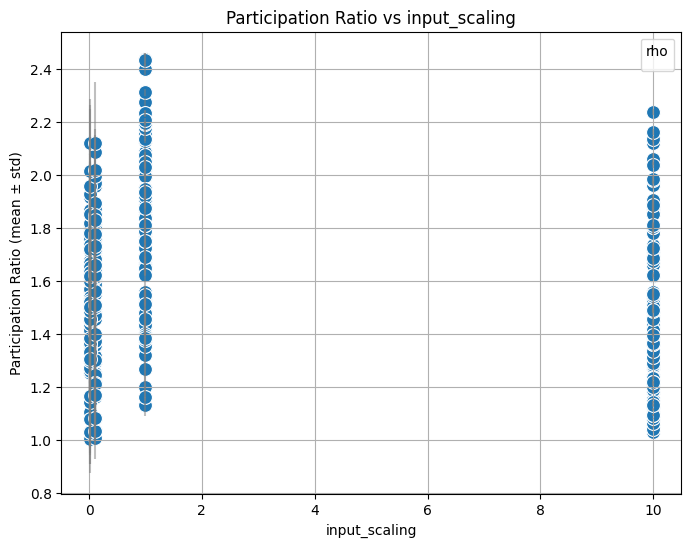

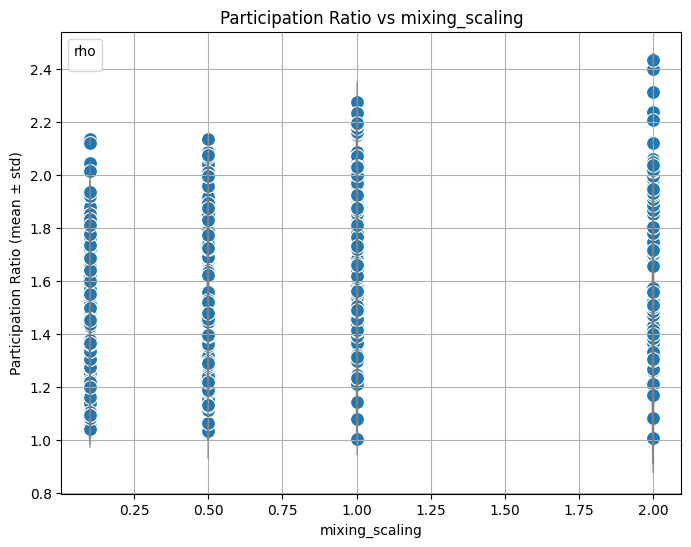

In [99]:
for p in hyperparams:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=grouped_df, x=p, y='pr_mean', palette='viridis', s=100)
    plt.errorbar(grouped_df[p], grouped_df['pr_mean'], yerr=grouped_df['pr_std'], fmt='none', c='gray', alpha=0.5)
    plt.title(f'Participation Ratio vs {p}')
    plt.xlabel(p)
    plt.ylabel('Participation Ratio (mean ± std)')
    plt.legend(title='rho')
    plt.grid(True)
    plt.show()
    


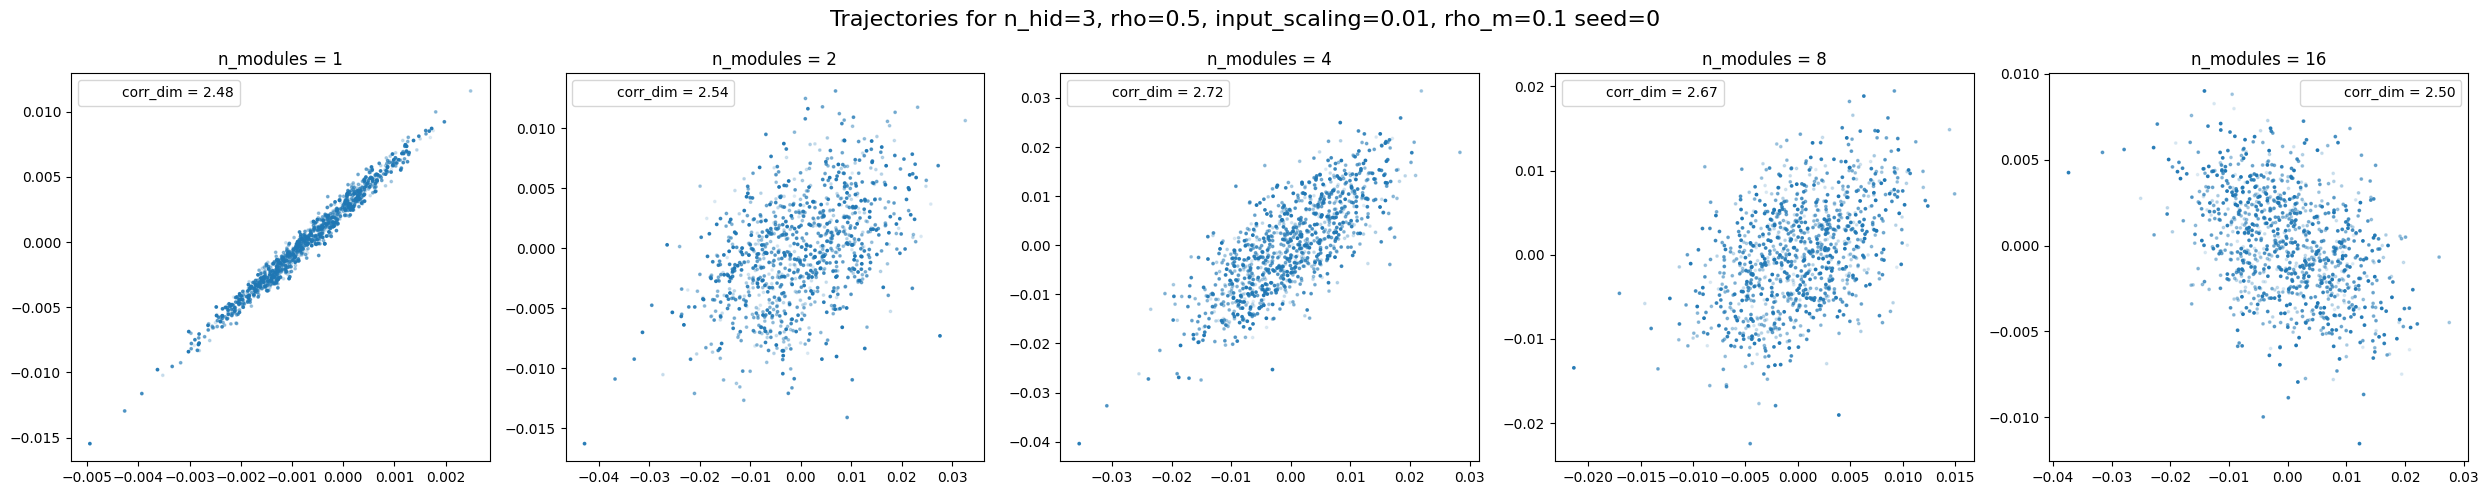

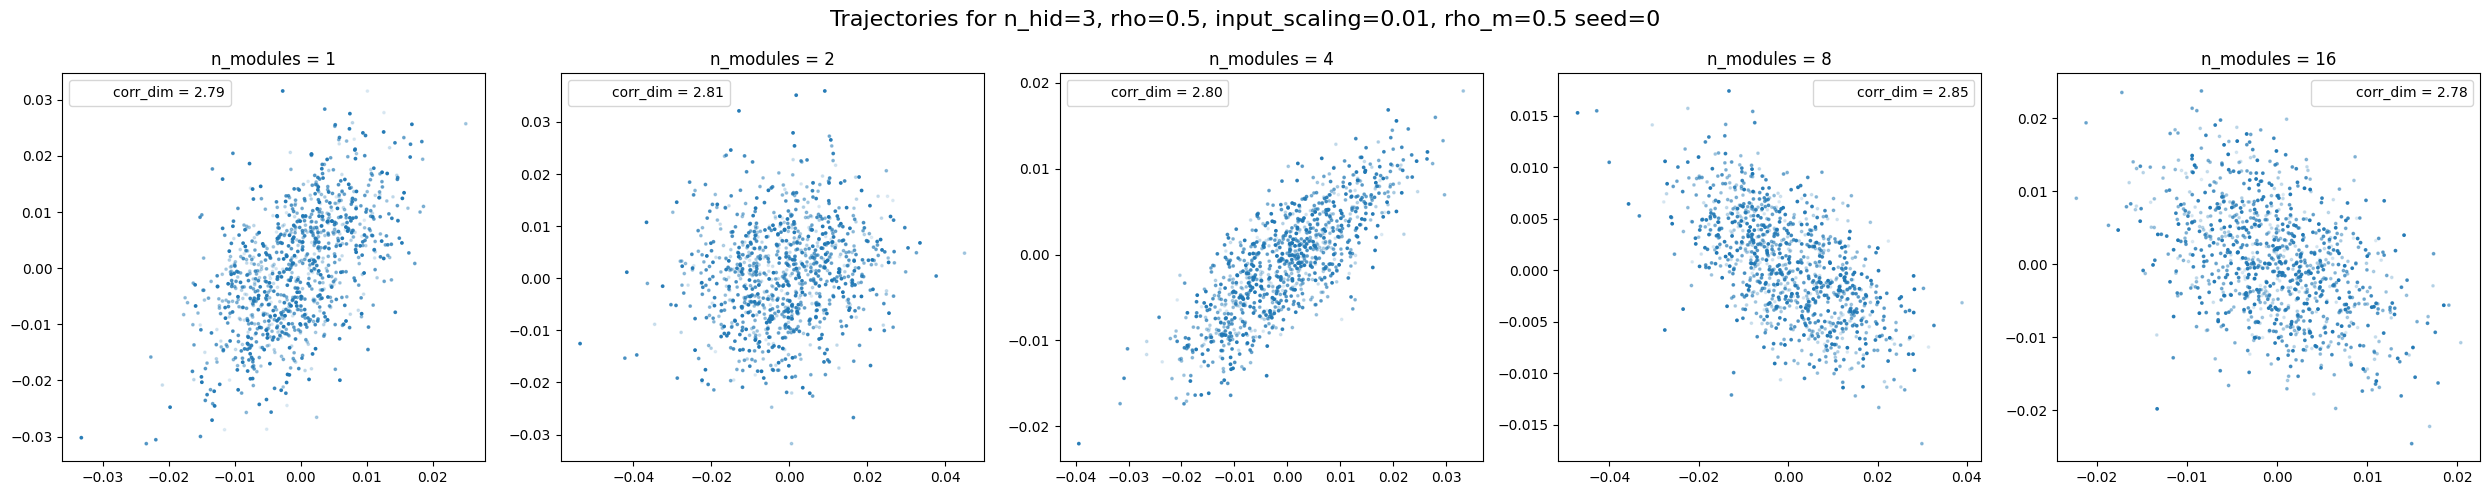

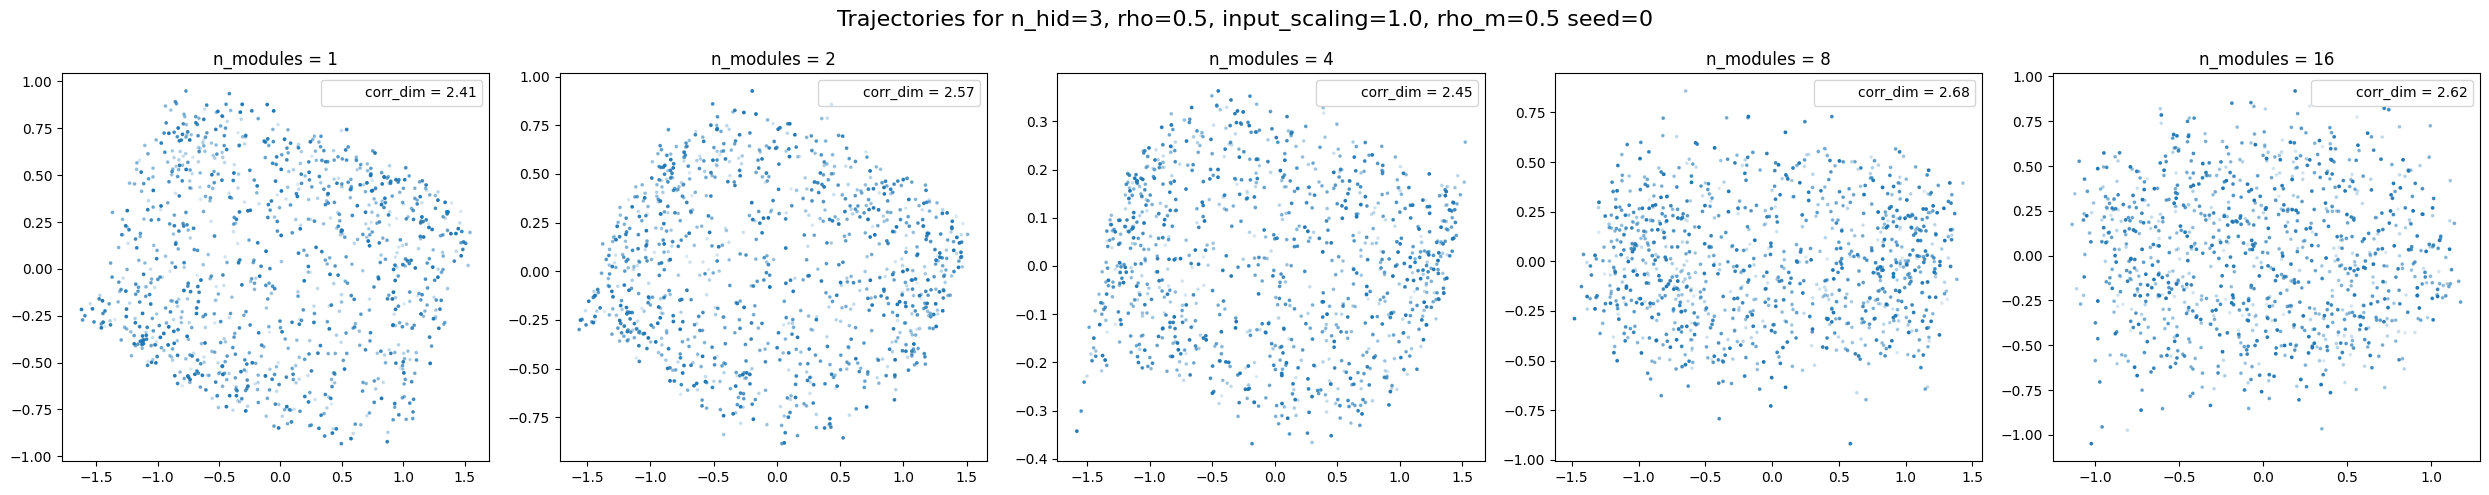

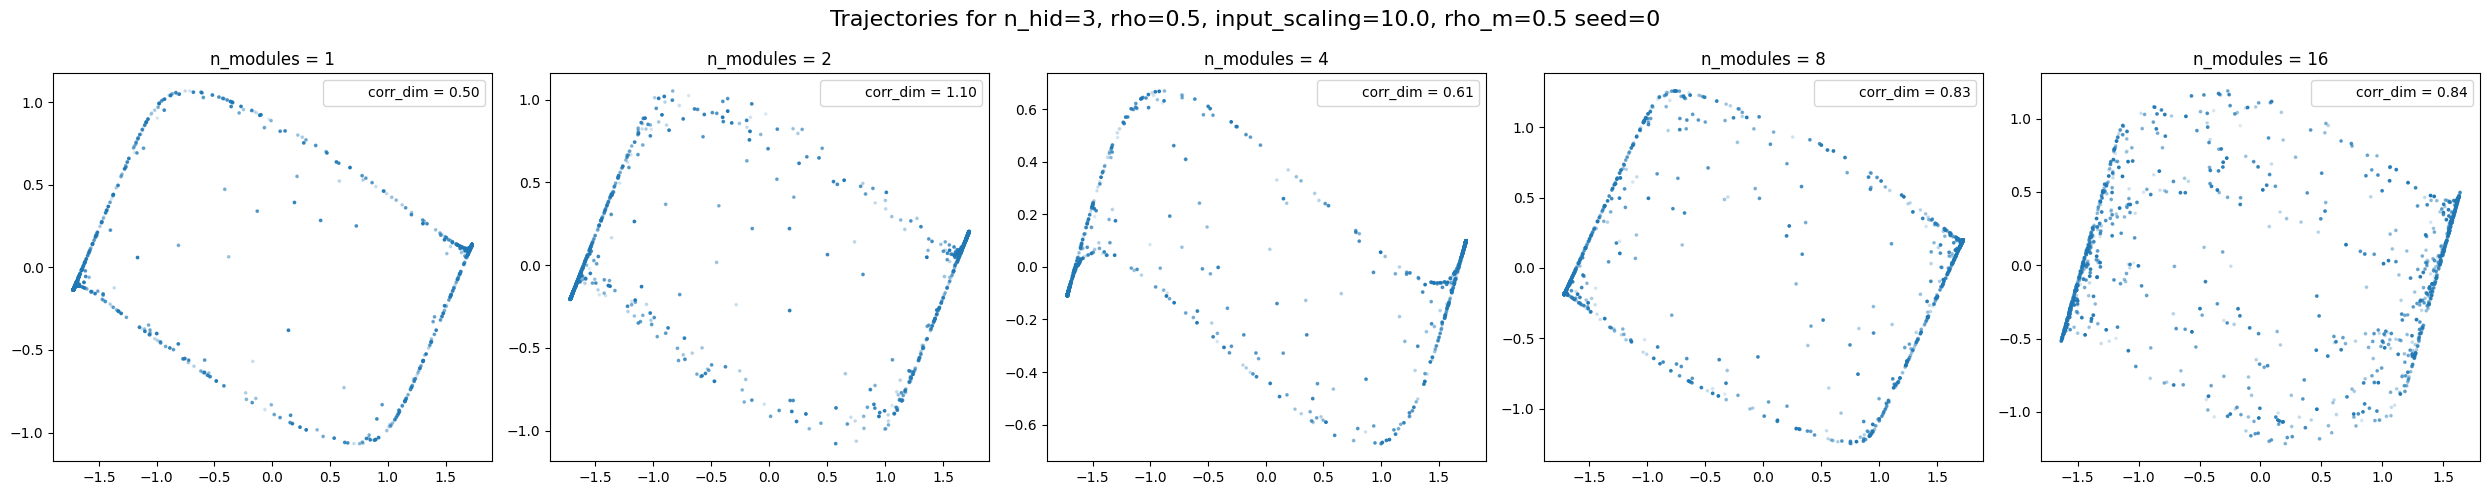

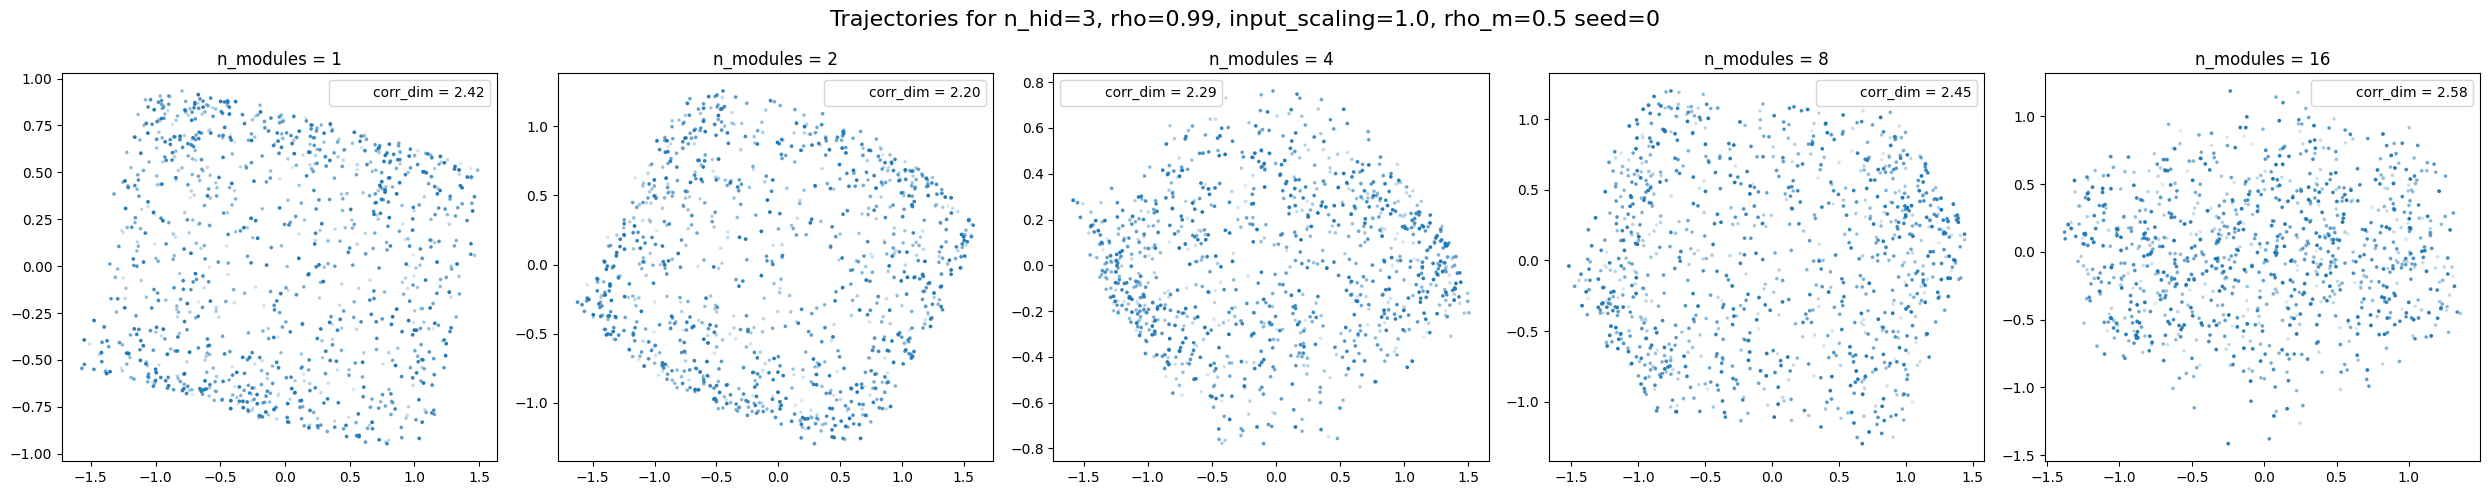

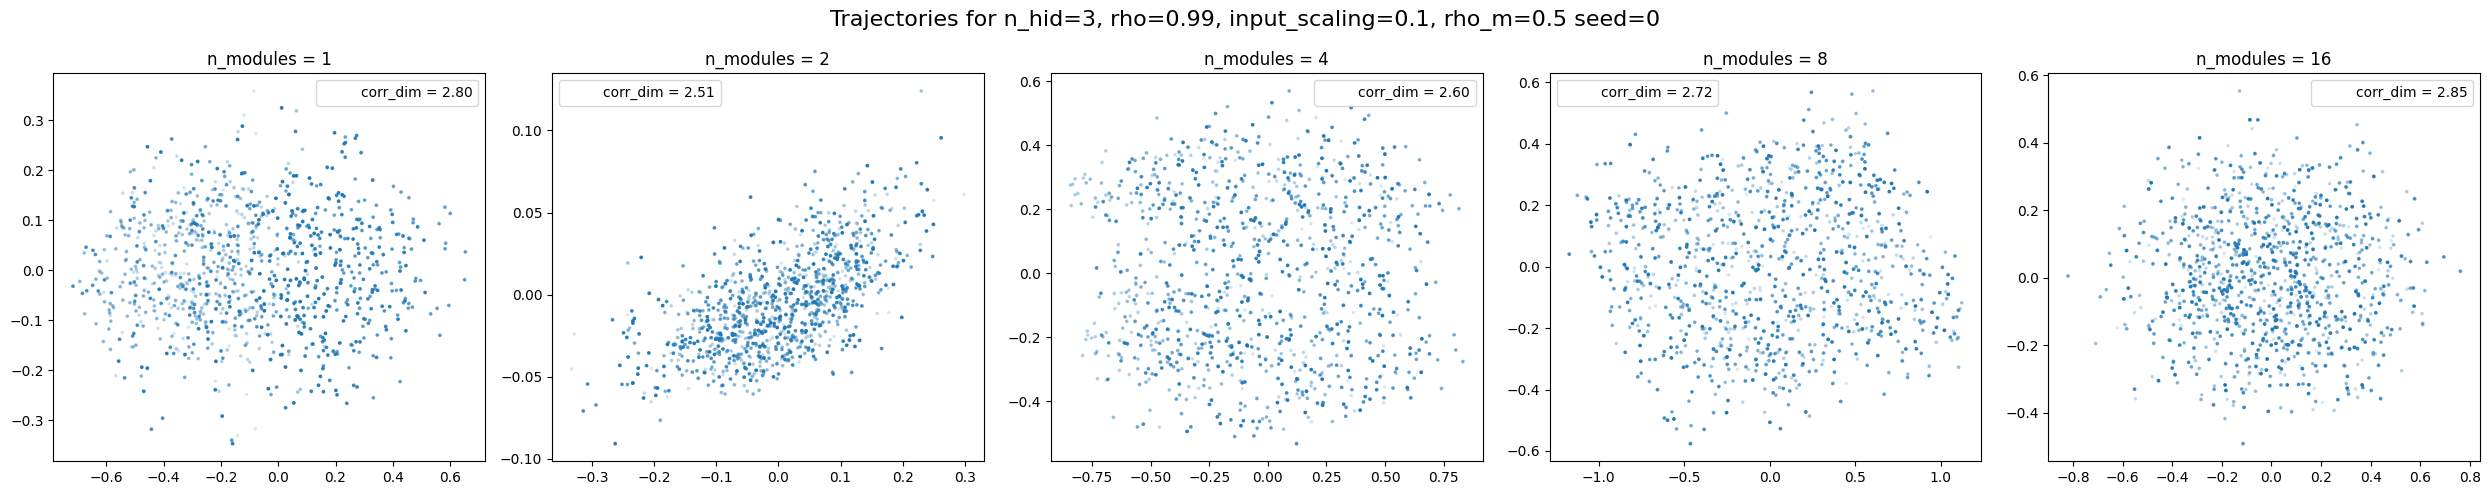

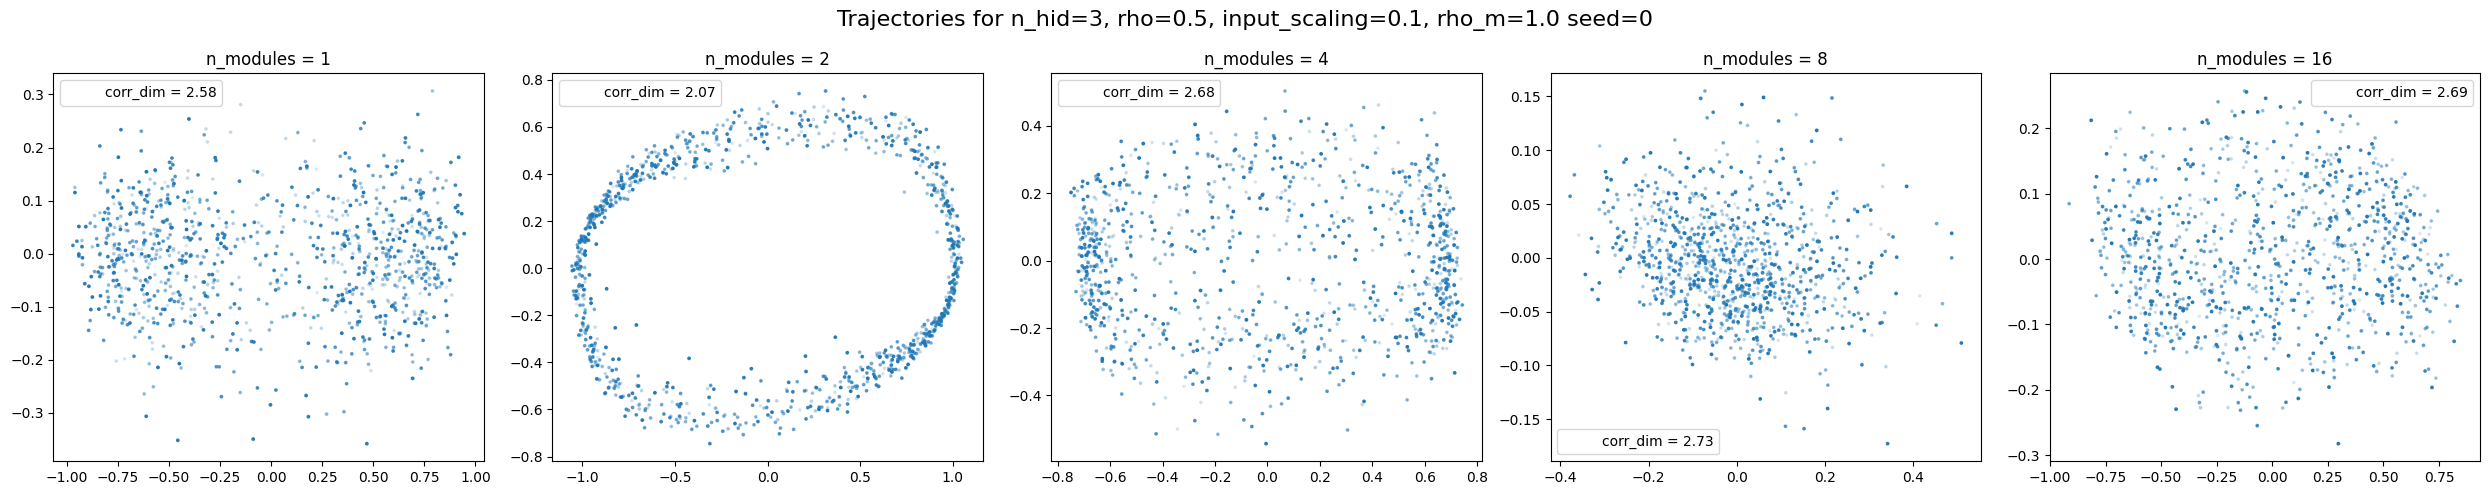

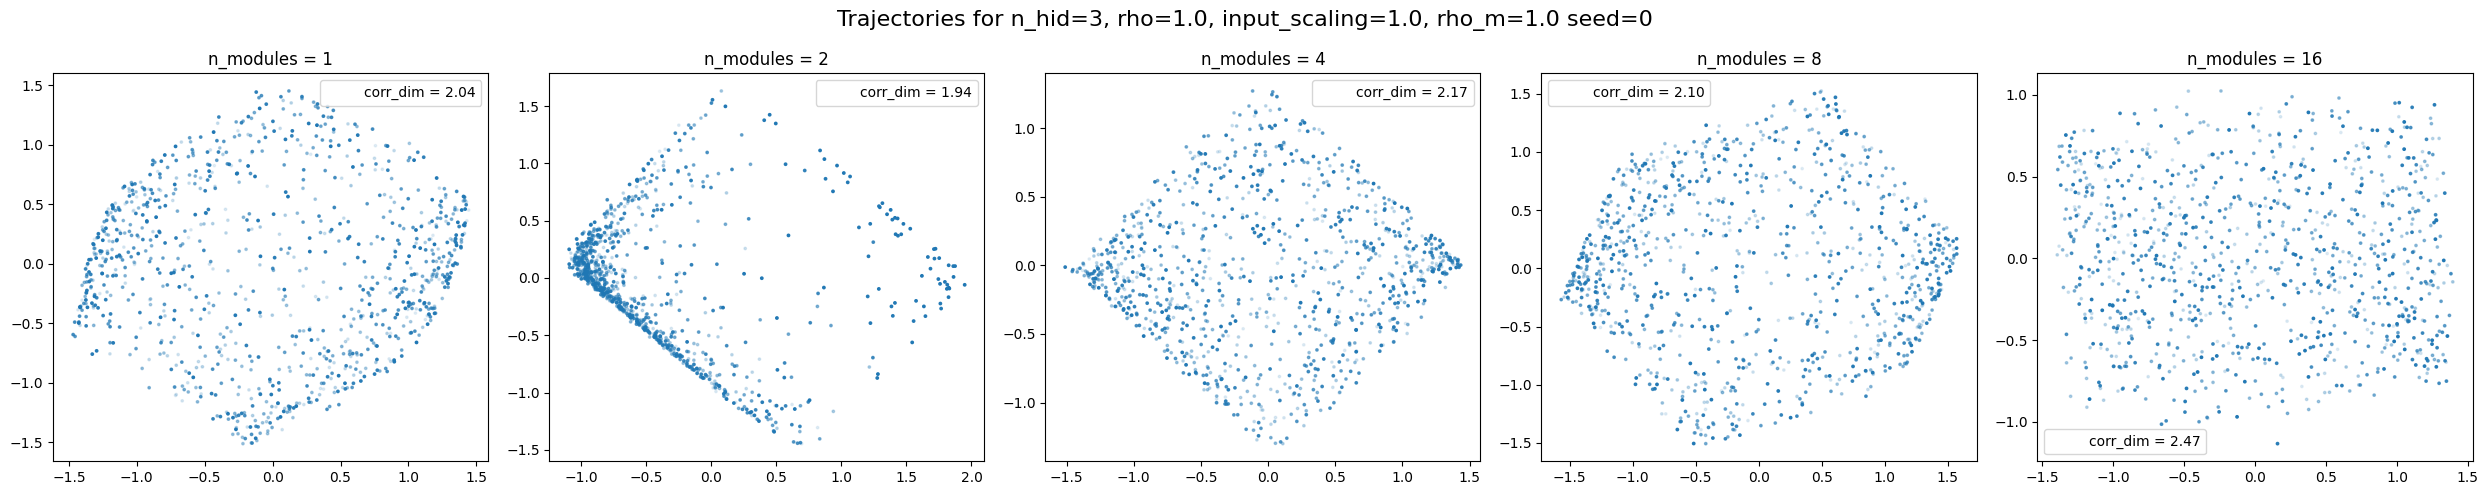

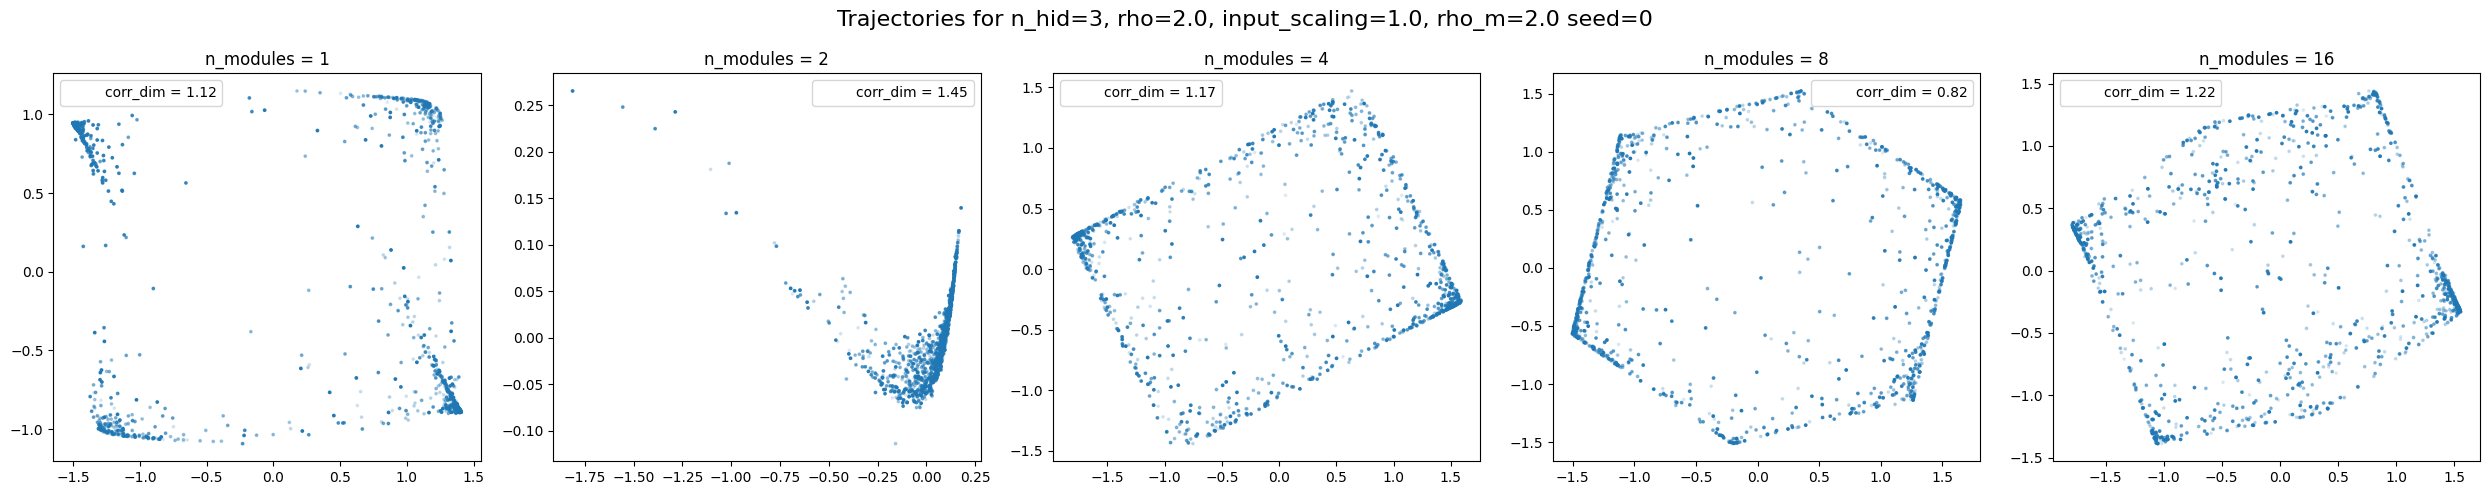

In [100]:
configs_to_plot = [
    {
        'n_hid': N_HID,
        'rho': 0.5,
        'input_scaling': 0.01,
        'rho_m': 0.1,
    },
    {
        'n_hid': N_HID,
        'rho': 0.5,
        'input_scaling': 0.01,
        'rho_m': 0.5,
    },
    {
        'n_hid': N_HID,
        'rho': 0.5,
        'input_scaling': 1.0,
        'rho_m': 0.5,
    },
    {
        'n_hid': N_HID,
        'rho': 0.5,
        'input_scaling': 10.0,
        'rho_m': 0.5,
    },
    {
        'n_hid': N_HID,
        'rho': 0.99,
        'input_scaling': 1.,
        'rho_m': 0.5,
    },
    {
        'n_hid': N_HID,
        'rho': 0.99,
        'input_scaling': 0.1,
        'rho_m': 0.5,
    },
    {
        'n_hid': N_HID,
        'rho': 0.5,
        'input_scaling': 0.1,
        'rho_m': 1.,
    },
        {
        'n_hid': N_HID,
        'rho': 1.,
        'input_scaling': 1.,
        'rho_m': 1.,
    },
            {
        'n_hid': N_HID,
        'rho': 2.,
        'input_scaling': 1.,
        'rho_m': 2.,
    },
]


for config in configs_to_plot:
    plot_selection(df, **config)

In [101]:
df_high_rhos = df[(df['rho'] >= 0.99) & (df['mixing_scaling'] >= 0.9)]

In [102]:
# compute correlation between corr_dim_mean and n_modules for df_high_rhos

corr = df_high_rhos['corr_dim_mean'].corr(df_high_rhos['n_modules'])
print(f"Correlation between corr_dim_mean and n_modules for high rho and mixing_scaling: {corr}")


Correlation between corr_dim_mean and n_modules for high rho and mixing_scaling: -0.060512804051221364


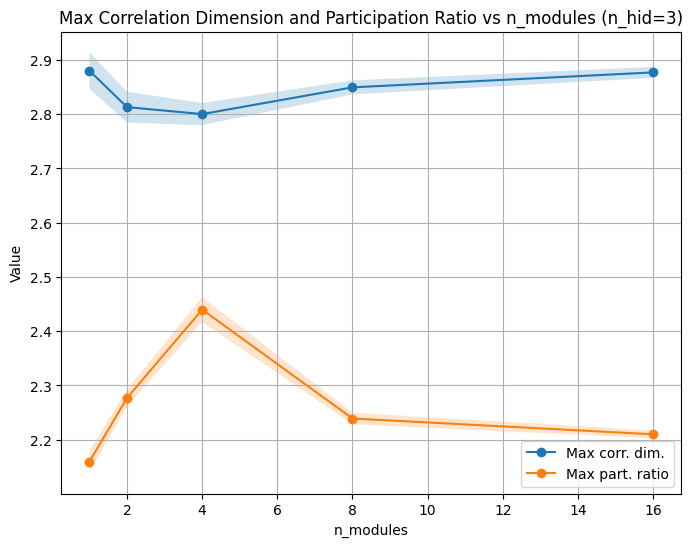

In [103]:
# plot line with highest values of corr_dim_mean and pr_mean with x=n_modules
plt.figure(figsize=(8,6))
max_corr_dim_per_n_modules = grouped_df.loc[grouped_df.groupby('n_modules')['corr_dim_mean'].idxmax()]
plt.plot(max_corr_dim_per_n_modules['n_modules'], max_corr_dim_per_n_modules['corr_dim_mean'], marker='o', label='Max corr. dim.')
max_pr_per_n_modules = grouped_df.loc[grouped_df.groupby('n_modules')['pr_mean'].idxmax()]
plt.plot(max_pr_per_n_modules['n_modules'], max_pr_per_n_modules['pr_mean'], marker='o', label='Max part. ratio')
# add shaded area for std
plt.fill_between(
    max_corr_dim_per_n_modules['n_modules'],
    max_corr_dim_per_n_modules['corr_dim_mean'] - max_corr_dim_per_n_modules['corr_dim_std'],
    max_corr_dim_per_n_modules['corr_dim_mean'] + max_corr_dim_per_n_modules['corr_dim_std'],
    alpha=0.2
)
plt.fill_between(
    max_pr_per_n_modules['n_modules'],
    max_pr_per_n_modules['pr_mean'] - max_pr_per_n_modules['pr_std'],
    max_pr_per_n_modules['pr_mean'] + max_pr_per_n_modules['pr_std'],
    alpha=0.2
)

plt.xlabel('n_modules')
plt.ylabel('Value')
plt.title(f'Max Correlation Dimension and Participation Ratio vs n_modules (n_hid={N_HID})')
plt.legend()
plt.grid(True)
plt.show()
